importing dependencies

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

function to read all the files for a

In [2]:
def read_csv_files_with_prefix(folder_path, prefix):
    csv_files = {}
    
    # List all files in the folder
    files = os.listdir(folder_path)
    
    # Filter files that start with the specified prefix and end with '.csv'
    csv_files_list = [file for file in files if file.startswith(prefix) and file.endswith('.csv')]
    
    # Read CSV files using pandas and store in the dictionary
    for csv_file in csv_files_list:
        file_path = os.path.join(folder_path, csv_file)
        data = pd.read_csv(file_path)
        csv_files[csv_file.replace(".csv","")] = data
    
    return csv_files

In [29]:
data=read_csv_files_with_prefix("dataset", 'a')
print(data.keys())
a1_raw=data['a1_raw']

dict_keys(['a1_raw', 'a1_va3', 'a2_raw', 'a3_raw', 'a3_va3'])


### dataviz-raw files-a1_raw

In [4]:
index_mapping={'Rest':0, 'Preparation':1, 'Stroke':2, 'Hold':3, 'Retraction':4}

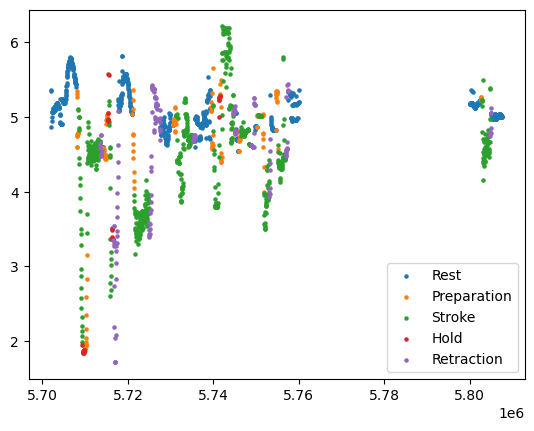

In [5]:
for phase in a1_raw['phase'].unique():
    plt.scatter(a1_raw[a1_raw['phase']==phase]['timestamp'],a1_raw[a1_raw['phase']==phase]['lhx'],label=phase,s=5)
plt.legend()
plt.show()

In [6]:
numerical_columns = a1_raw.columns[:-1]
phase_data = {}
phases=a1_raw['phase'].unique()

for phase, group in a1_raw.groupby('phase'):
    phase_data[phase] = group[numerical_columns]

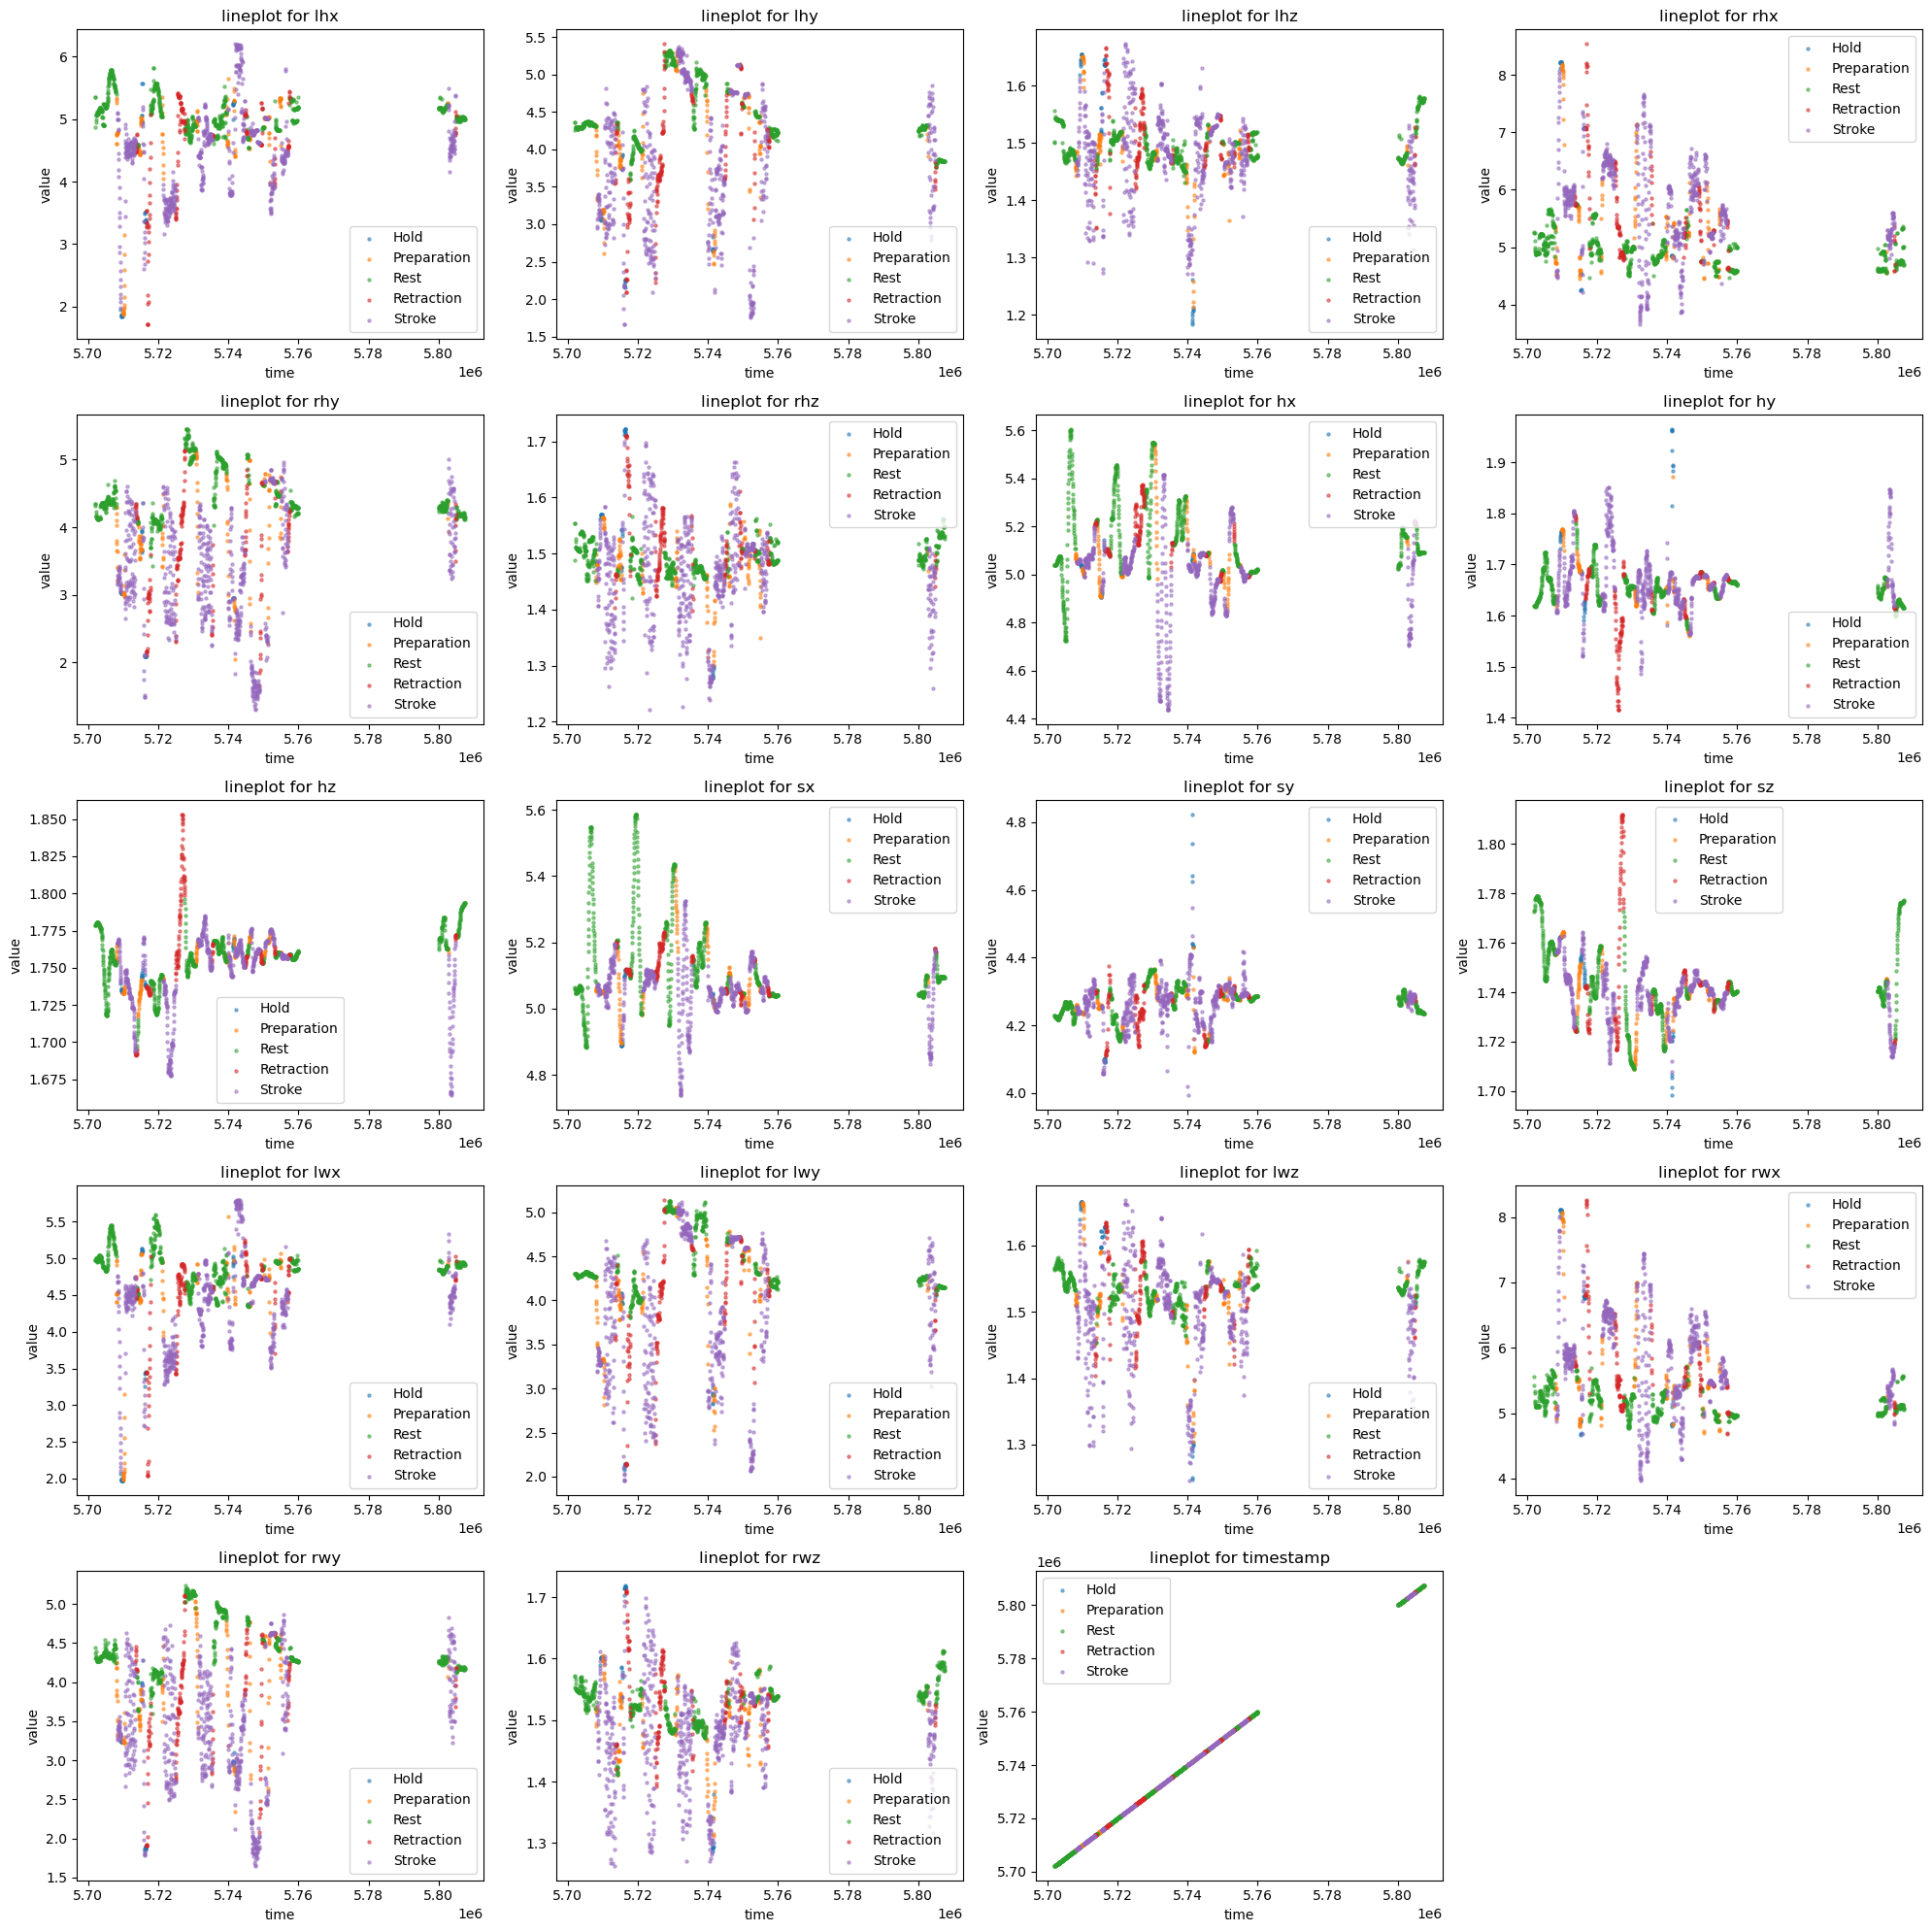

In [7]:
num_rows = 5
num_cols = (len(numerical_columns) + num_rows - 1) // num_rows

plt.figure(figsize=[20, 20])
for i,col in enumerate(numerical_columns):
    plt.subplot(num_rows, num_cols, i + 1)
    for (phase, values) in (phase_data.items()):
        plt.scatter(values['timestamp'],values[col], alpha=0.5,s=5, label=phase) 
        
    plt.xlabel('time')
    plt.ylabel('value')
    plt.title(f'lineplot for {col}')
    plt.legend()

plt.tight_layout()
plt.show()

from these time plots:
- gestures occour in a rest-[preparation-stroke-reaction] rest cycles with holds in between
- stroke values are highly variable (vary over large y values) so hard to predict off of x,y,z values
- examples for hold are very less compared to other phases
- rest positions are really stable/people tend to pause in same positions
- the y in hold are generally higher while x are lower implying hands close to chest
- higher y for most of the time in reaction  phase

for further analysis all the coordinates will be centered to the spine and normalized to height

In [8]:
sx=a1_raw['sx']
sy=a1_raw['sy']
sz=a1_raw['sz']
hx=a1_raw['hx']
hy=a1_raw['hy']
hz=a1_raw['hz']

In [9]:
for column in a1_raw.columns[:-2]:
    if 'x' in column:
        a1_raw[column]-=sx
        a1_raw[column]/=(hx-sx)
    elif 'y' in column:
        a1_raw[column]-=sy
        a1_raw[column]/=(hy-sy)
    elif 'z' in column:
        a1_raw[column]-=sz
        a1_raw[column]/=(hz-sz)

In [10]:
a1_raw_cent=a1_raw.drop(['sx','sy','sz','hx','hy','hz'],axis=1)
a1_raw_cent

,lhx,lhy,lhz,rhx,rhy,rhz,lwx,lwy,lwz,rwx,rwy,rwz,timestamp,phase
0,-11.416332,-0.051324,-46.884462,-7.867961,-0.034314,-49.172701,3.605848,-0.027346,-35.994457,-19.699262,-0.053918,-37.944916,5702026,Rest
1,8.052393,-0.009849,-37.928946,-7.501385,-0.045145,-38.248162,3.632326,-0.028792,-36.284914,-15.215995,-0.028812,-35.512251,5702058,Rest
2,-13.722424,-0.052127,-52.362466,-8.268510,-0.045952,-42.147138,3.572454,-0.029643,-40.323665,-12.559247,-0.080491,-38.556857,5702089,Rest
3,5.994459,-0.021082,-52.584410,-2.900470,-0.001062,-57.063653,3.658082,-0.029587,-48.106550,-13.437596,-0.065132,-48.005304,5702120,Rest
4,3.322552,-0.020353,-68.654470,4.493923,0.016625,-75.304220,4.622215,-0.027376,-60.680732,-9.547265,-0.042180,-63.556211,5702167,Rest
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1742,44.311475,0.150763,-11.994823,48.864169,0.042237,-13.863885,85.661358,0.034446,-12.140329,-12.585480,0.023468,-11.228463,5807375,Rest
1743,63.307587,0.150784,-11.928819,272.532468,0.033330,-14.735178,123.651401,0.034502,-12.073273,14.881750,0.023212,-11.724181,5807406,Rest
1744,150.749216,0.150433,-11.862419,616.034483,0.035960,-14.714798,289.128527,0.034160,-12.006873,29.844828,0.021812,-11.667643,5807437,Rest
1745,105.233634,0.150016,-11.932359,454.880361,0.030753,-15.013840,204.879233,0.033712,-12.077167,39.762980,0.025798,-11.825954,5807499,Rest


In [11]:
one_hot_a1_raw=pd.get_dummies(a1_raw_cent, columns = ['phase'])
correlations=one_hot_a1_raw.corr().iloc[:,-5:][:-6]

In [12]:
correlations

,phase_Hold,phase_Preparation,phase_Rest,phase_Retraction,phase_Stroke
lhx,0.030106,-0.070935,-0.006727,0.010685,0.033340
lhy,0.240651,-0.009359,-0.337155,0.085041,0.218423
lhz,-0.000609,-0.002013,0.034852,-0.017288,-0.022717
rhx,-0.054054,0.058221,0.013667,-0.014720,-0.022817
rhy,0.170897,-0.020727,-0.577431,0.072661,0.497541
rhz,-0.000641,-0.001868,0.033805,-0.016223,-0.022421
lwx,0.030273,-0.072466,-0.000781,0.007237,0.030416
lwy,0.245111,-0.014478,-0.365691,0.070289,0.258507
lwz,-0.000533,-0.002371,0.035030,-0.017521,-0.022555
rwx,-0.048238,0.059345,0.008343,-0.011580,-0.021905


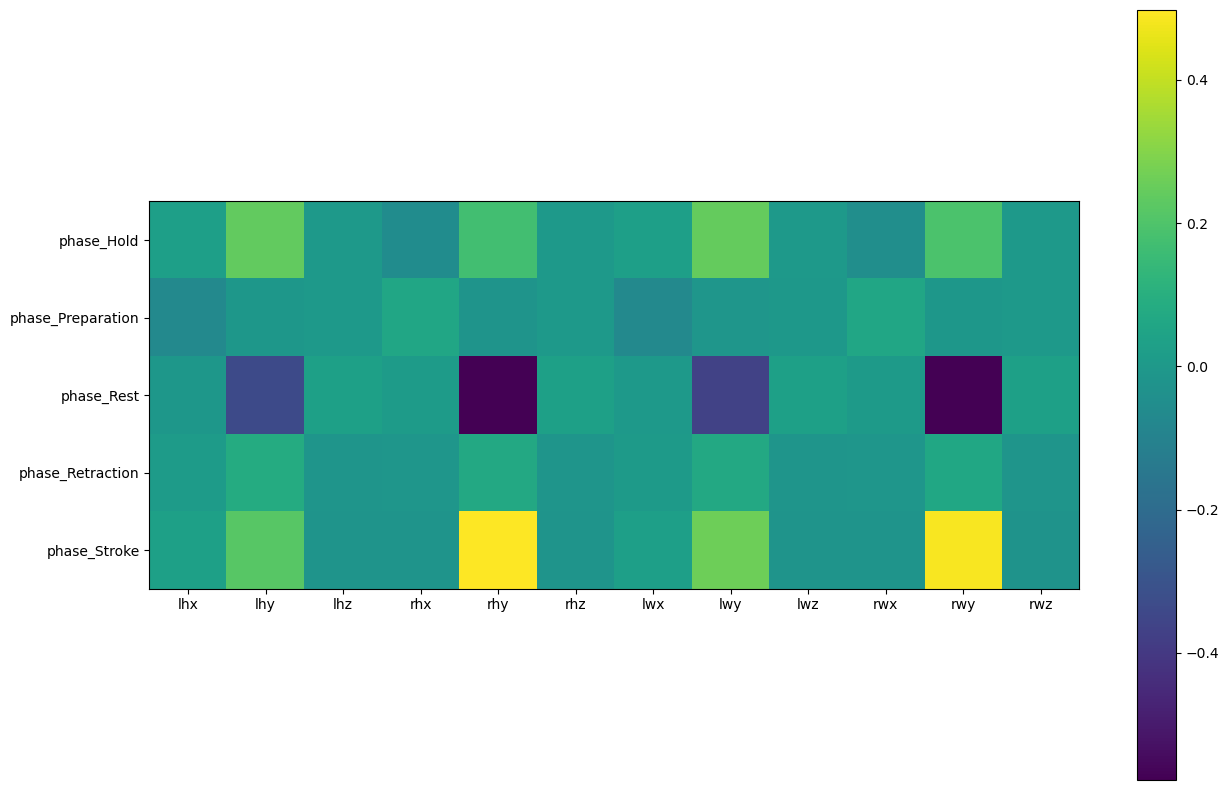

In [13]:
phases=['phase_Hold','phase_Preparation','phase_Rest','phase_Retraction','phase_Stroke']
col=correlations.index
plt.figure(figsize=[15, 10])
plt.imshow(np.array(correlations).T)
plt.colorbar()
plt.yticks(range(len(phases)), phases)
plt.xticks(range(len(col)), col)
plt.show()

- hand and wrist heights are the best features for prediction
- other features are more or less uncorrelated for prediction
- reaction phase and preparation phase are also very uncorrelated to given features
- x positions are of hands and wrist are slightly correlated to preparation phase

![](phase.png)

In [33]:
a2_raw=data['a2_raw']

In [39]:
sx2=a2_raw['sx']
sy2=a2_raw['sy']
sz2=a2_raw['sz']
hx2=a2_raw['hx']
hy2=a2_raw['hy']
hz2=a2_raw['hz']
for column in a2_raw.columns[:-2]:
    if 'x' in column:
        a2_raw[column]-=sx2
        a2_raw[column]/=(hx2-sx2)
    elif 'y' in column:
        a2_raw[column]-=sy2
        a2_raw[column]/=(hy2-sy2)
    elif 'z' in column:
        a2_raw[column]-=sz2
        a2_raw[column]/=(hz2-sz2)
a2_raw_cent=a2_raw.drop(['sx','sy','sz','hx','hy','hz'],axis=1)
a2_raw_cent

,lhx,lhy,lhz,rhx,rhy,rhz,lwx,lwy,lwz,rwx,rwy,rwz,timestamp,phase
0,23.021064,-0.559354,-18.209744,-28.762498,-0.502200,-26.220892,22.865074,-0.413963,-15.239678,-22.032392,-0.416162,-25.396367,5103698,Rest
1,22.663005,-0.545671,-19.212981,-28.325969,-0.492864,-27.447745,22.496883,-0.399773,-16.382398,-21.708616,-0.406607,-26.583498,5103729,Rest
2,22.267333,-0.537056,-17.961905,-27.760404,-0.502479,-26.274327,22.176874,-0.391125,-15.316149,-21.268216,-0.416158,-25.491925,5103762,Rest
3,22.261696,-0.563887,-17.764567,-28.647634,-0.484337,-23.562795,21.120124,-0.417572,-17.444094,-21.194142,-0.429400,-23.841339,5103795,Rest
4,22.344629,-0.563873,-18.265631,-27.854914,-0.496260,-25.541020,21.254864,-0.417486,-17.573477,-21.443524,-0.407081,-25.104540,5103827,Rest
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1259,-15.648449,-0.325305,19.650645,13.455093,-0.279893,42.422040,-13.061116,-0.228238,14.649277,12.078784,-0.192792,34.744627,5155770,Retraction
1260,-19.525407,-0.357913,11.388344,17.005312,-0.308155,25.412270,-14.862883,-0.325559,9.618650,15.803053,-0.249403,22.481718,5155833,Retraction
1261,-16.250608,-0.378794,12.149273,14.181582,-0.345000,30.918538,-12.421330,-0.328104,11.338764,13.521274,-0.270613,24.947013,5155902,Retraction
1262,-13.746699,-0.398750,11.355250,12.144059,-0.361183,30.920355,-10.570630,-0.337051,12.236187,11.236716,-0.278781,25.764459,5155939,Retraction


In [40]:
numerical_columns = a2_raw_cent.columns[:-1]
phase_data = {}
phases=a2_raw_cent['phase'].unique()

for phase, group in a2_raw_cent.groupby('phase'):
    phase_data[phase] = group[numerical_columns]

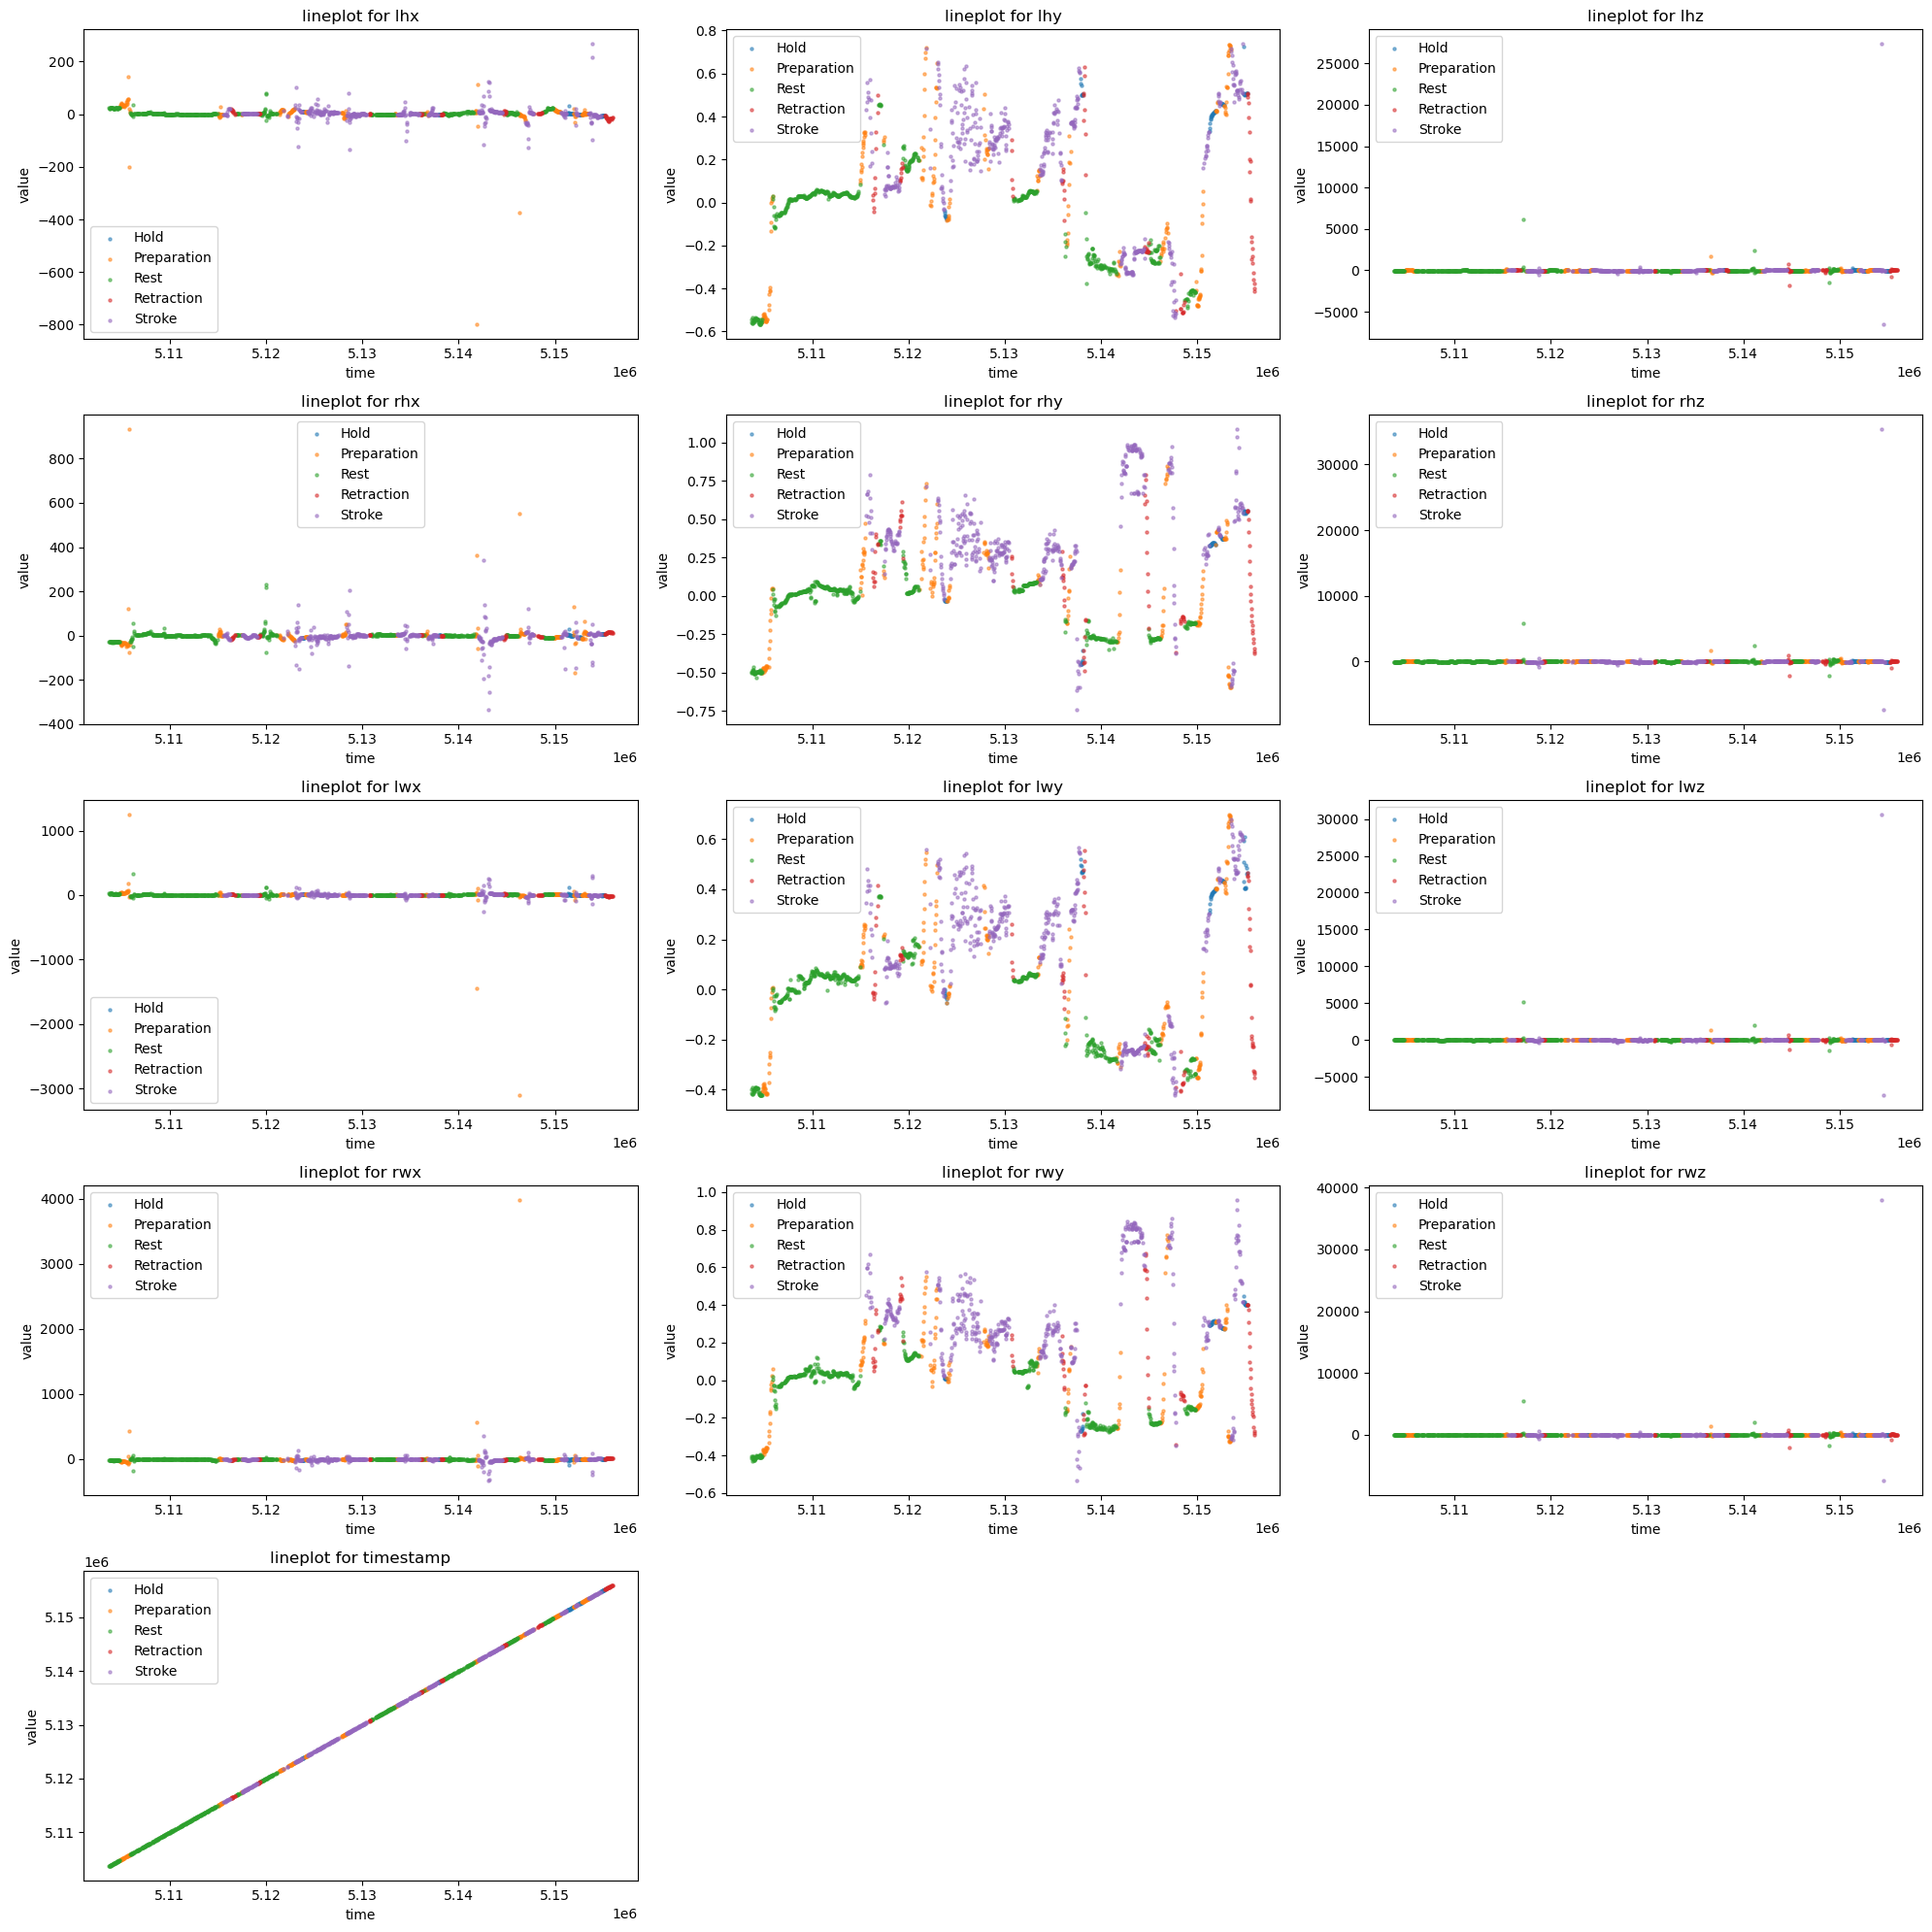

In [41]:
num_rows = 5
num_cols = (len(numerical_columns) + num_rows - 1) // num_rows

plt.figure(figsize=[20, 20])
for i,col in enumerate(numerical_columns):
    plt.subplot(num_rows, num_cols, i + 1)
    for (phase, values) in (phase_data.items()):
        plt.scatter(values['timestamp'],values[col], alpha=0.5,s=5, label=phase) 
        
    plt.xlabel('time')
    plt.ylabel('value')
    plt.title(f'lineplot for {col}')
    plt.legend()
plt.tight_layout()
plt.show()

normalized plots for wrist and hands are similar(as should be)

### dataviz-va3 files

naming the columns correctly

In [42]:
corrected_columns = [
    "vlhx", "vlhy", "vlhz", "vrhx", "vrhy", "vrhz","vlwx", "vlwy", "vlwz", "vrwx", "vrwy", "vrwz","alhx", "alhy", "alhz", "arhx", "arhy", "arhz","alwx", "alwy", "alwz", "arwx", "arwy", "arwz","svlh", "svrh", "svlw", "svrw","salh", "sarh", "salw", "sarw","phase"
]
def correct_columns(data,corrected_columns):
    for csv in data.keys():
        if "va" in csv:
            data[csv].columns=corrected_columns

In [43]:
correct_columns(data,corrected_columns)
data['a1_va3'].columns

Index(['vlhx', 'vlhy', 'vlhz', 'vrhx', 'vrhy', 'vrhz', 'vlwx', 'vlwy', 'vlwz',
       'vrwx', 'vrwy', 'vrwz', 'alhx', 'alhy', 'alhz', 'arhx', 'arhy', 'arhz',
       'alwx', 'alwy', 'alwz', 'arwx', 'arwy', 'arwz', 'svlh', 'svrh', 'svlw',
       'svrw', 'salh', 'sarh', 'salw', 'sarw', 'phase'],
      dtype='object')

In [44]:
a1_va3=data['a1_va3']

In [45]:
numerical_columns = a1_va3.columns[:-1]
phase_data = {}
phases=a1_va3['phase'].unique()

for phase, group in a1_va3.groupby('phase'):
    phase_data[phase] = group[numerical_columns]

plotting the first 200 occourances of each class

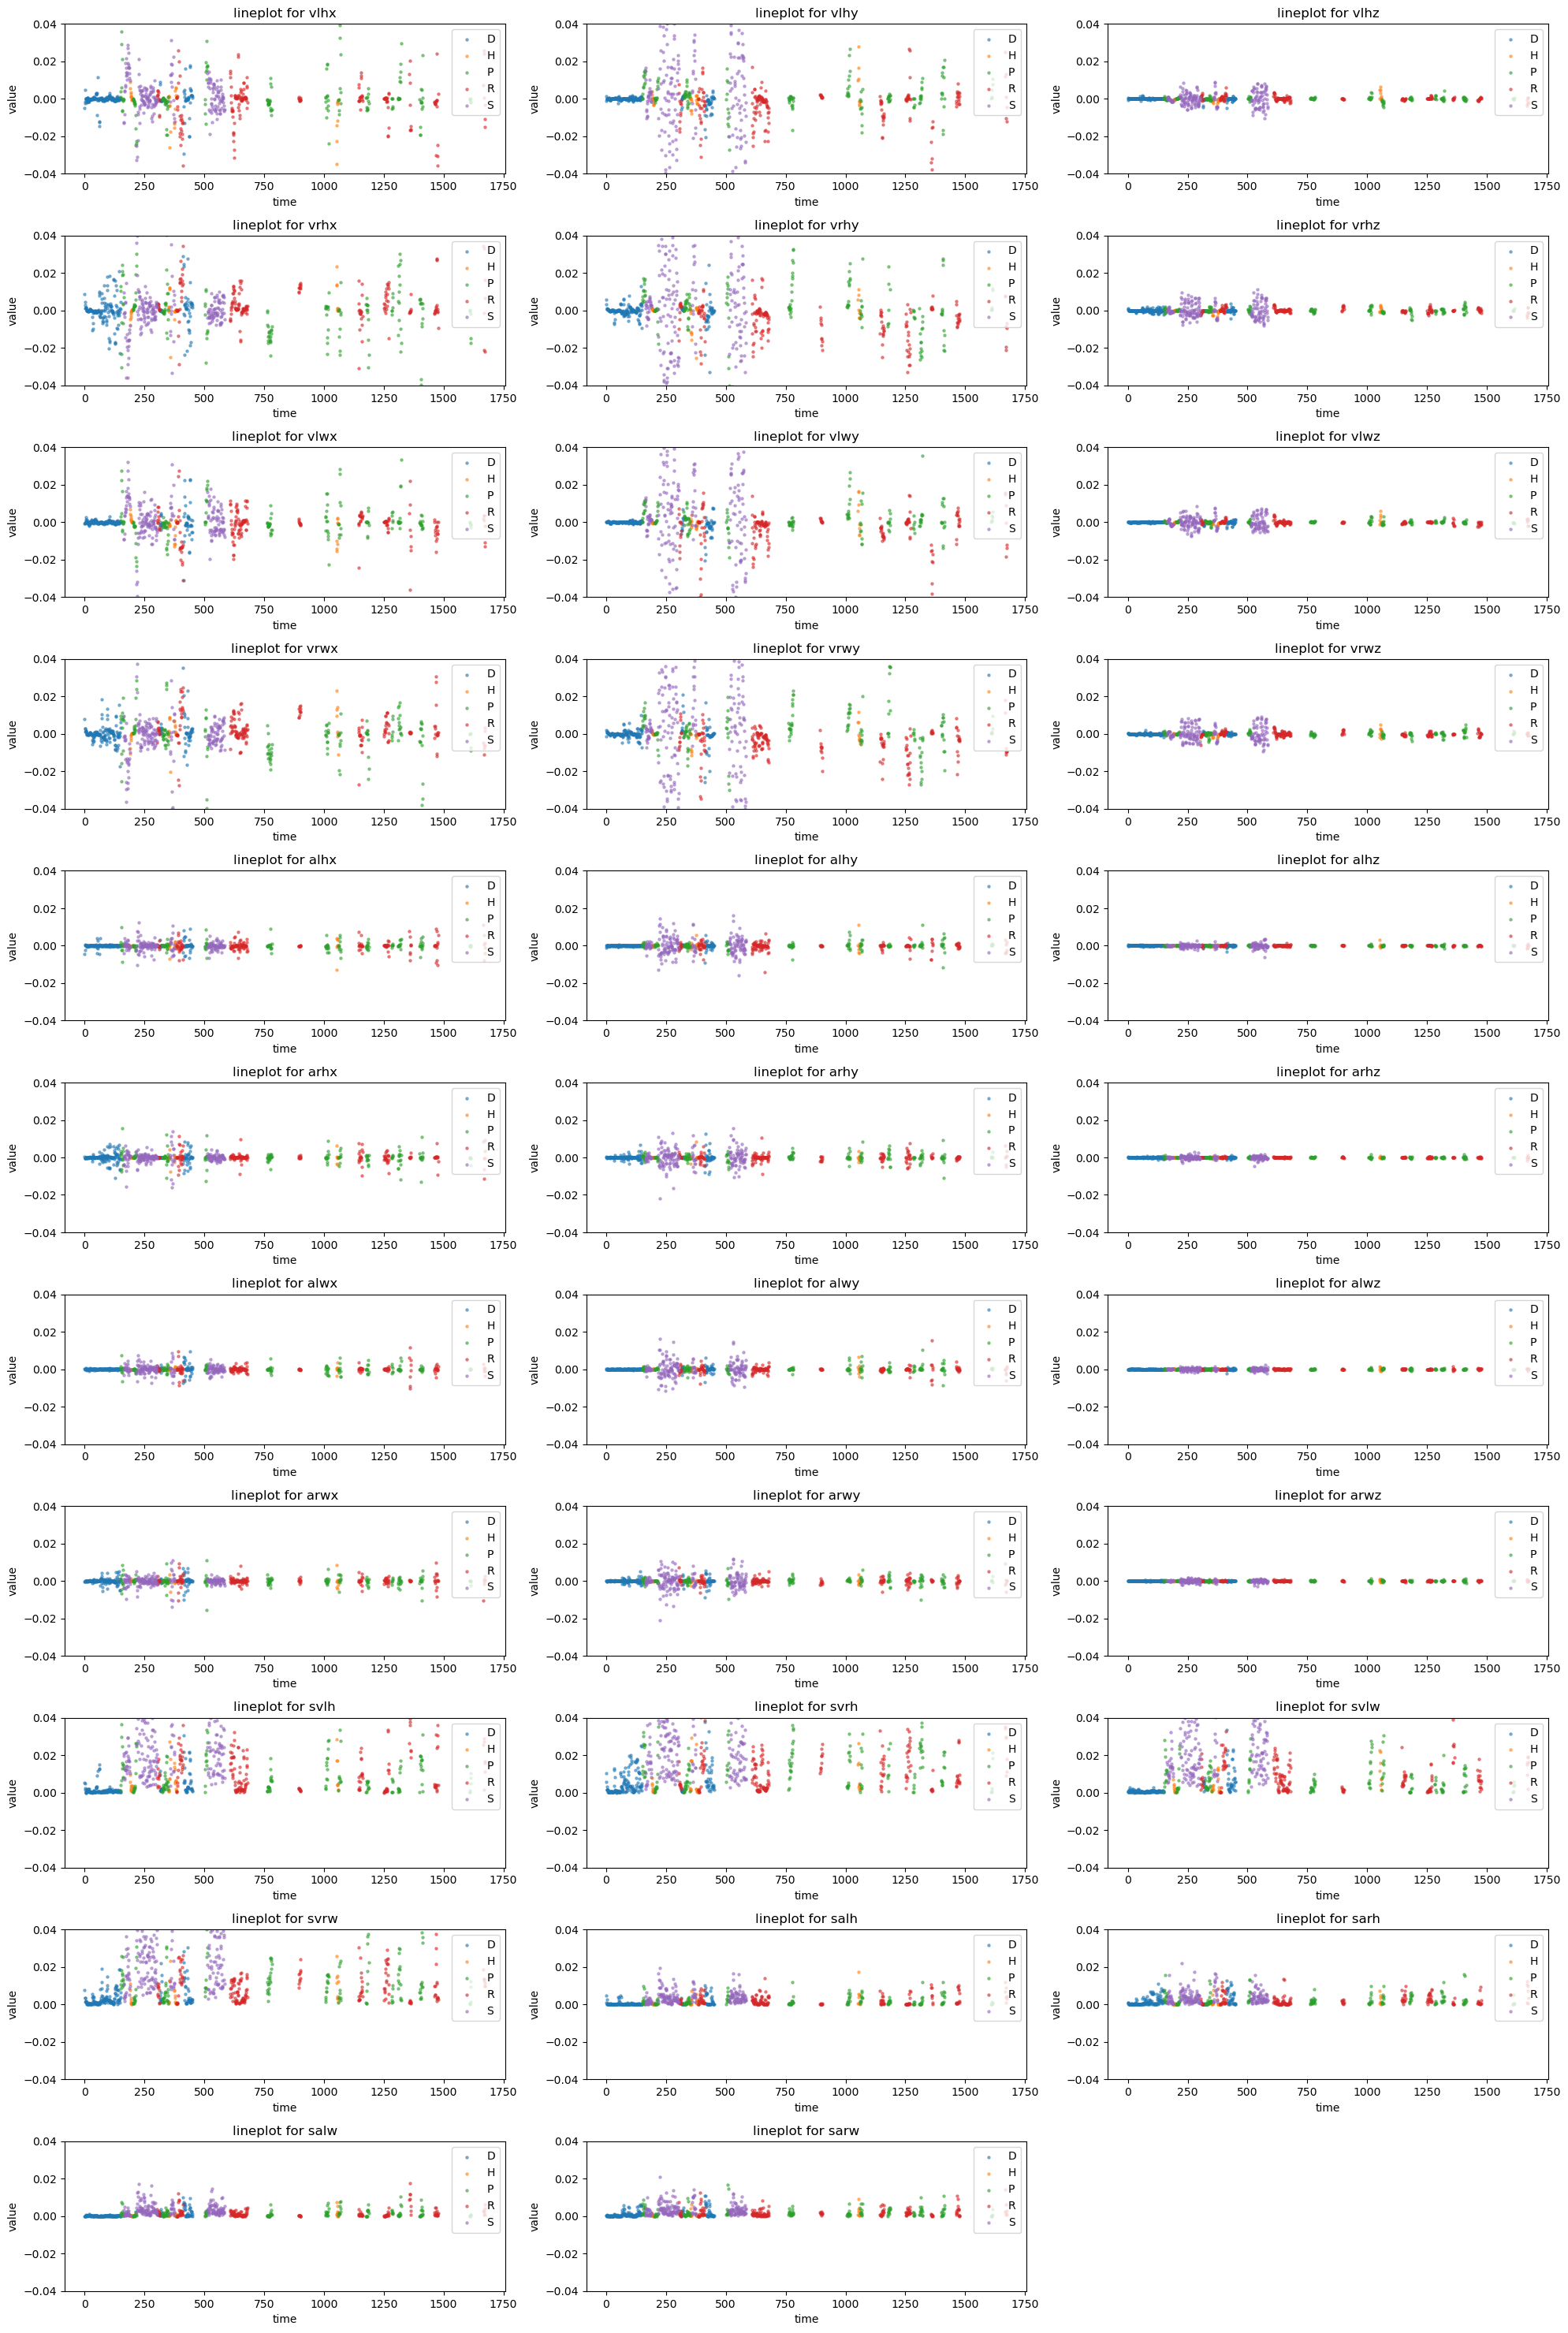

In [47]:
num_rows = 15
num_cols = (len(numerical_columns) + num_rows - 1) // num_rows


plt.figure(figsize=[20, 40])
for i,col in enumerate(numerical_columns):
    plt.subplot(num_rows, num_cols, i + 1)
    for (phase, values) in (phase_data.items()):
        plt.scatter(values.index[0:200],values[col][0:200], alpha=0.5,s=5, label=phase) 
        
    plt.xlabel('time')
    plt.ylabel('value')
    plt.title(f'lineplot for {col}')
    plt.ylim(-0.04,0.04)
    plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

- scalar and vector velocity for rest(D) are close to zero
- a stroke generally has the maximum amount of movement
- movement in the z direction is small
- x and y directions have similar variations

In [48]:
one_hot_a1_va3=pd.get_dummies(a1_va3, columns = ['phase'])
correlations=one_hot_a1_va3.corr().iloc[:,-5:][:-5]
correlations

,phase_D,phase_H,phase_P,phase_R,phase_S
vlhx,-0.012407,-0.059714,0.016506,-0.046025,0.050522
vlhy,-0.014138,0.007656,0.062419,-0.094079,0.035094
vlhz,-0.018747,0.005568,0.005246,0.026640,-0.003086
vrhx,0.026252,0.015649,-0.053193,0.100643,-0.064225
vrhy,-0.022329,-0.014995,0.077425,-0.139363,0.070464
vrhz,-0.019420,-0.021400,0.004306,0.017786,0.012100
vlwx,-0.014352,-0.041257,0.016029,-0.055125,0.053006
vlwy,-0.009086,0.006528,0.059932,-0.102787,0.037443
vlwz,-0.017900,-0.004230,0.019885,0.002791,0.005628
vrwx,0.033251,0.023859,-0.054275,0.087483,-0.064668


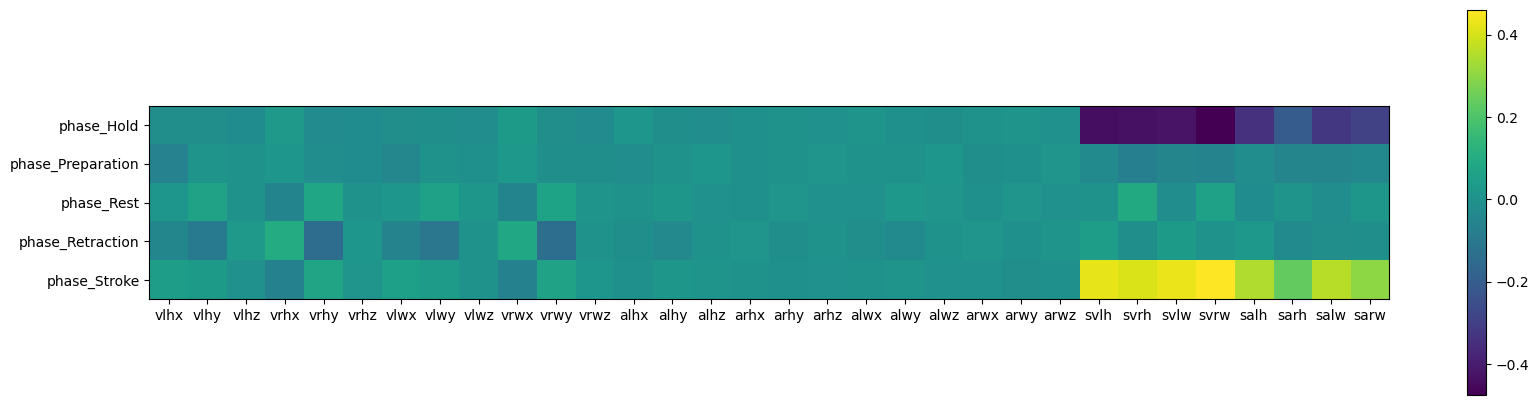

In [49]:
phases=['phase_Hold','phase_Preparation','phase_Rest','phase_Retraction','phase_Stroke']
col=correlations.index
plt.figure(figsize=[20,5])
plt.imshow(np.array(correlations).T)
plt.colorbar()
plt.yticks(range(len(phases)), phases)
plt.xticks(range(len(col)), col)
plt.show()

- correlation with accelaration are really bad
- scalar velocity have high correlation and low correaltions with stroke and hold(as expected)

## train test split

In [50]:
train_set, test_set = train_test_split(a1_va3, test_size=0.2,stratify=a1_va3['phase'], random_state=42)

In [51]:
oe=OrdinalEncoder()
scaler=StandardScaler()

In [52]:
num_attribs=train_set.columns[:-1]
cat_attribs=train_set.columns[-1:]
pipeline = ColumnTransformer([
 ("num", scaler, num_attribs),
 ("cat", oe, cat_attribs),
 ])

In [53]:
train_f=pd.DataFrame(pipeline.fit_transform(train_set),columns=train_set.columns)

In [54]:
X_train=train_f[train_f.columns[:-1]]
y_train=train_f[train_f.columns[-1:]]

In [55]:
rnd_clf1 = RandomForestClassifier(n_estimators=500,n_jobs=-1)
rnd_clf1.fit(X_train, y_train)

C:\Users\sarit\AppData\Local\Temp\ipykernel_31544\3489332932.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rnd_clf1.fit(X_train, y_train)


RandomForestClassifier(n_estimators=500, n_jobs=-1)

In [57]:
test_f=pd.DataFrame(pipeline.transform(test_set),columns=test_set.columns)
X_test=test_f[test_f.columns[:-1]]
y_test=test_f[test_f.columns[-1:]]

In [56]:
def f1_score(confusion_matrix):
    num_classes = len(confusion_matrix)
    precision = np.zeros(num_classes)
    recall = np.zeros(num_classes)
    f1_score = np.zeros(num_classes)
    
    for i in range(num_classes):
        TP = confusion_matrix[i][i]
        FP = np.sum(confusion_matrix, axis=1)[i] - TP
        FN = np.sum(confusion_matrix, axis=0)[i] - TP
        precision[i] = TP / (TP + FP) if TP + FP != 0 else 0
        recall[i] = TP / (TP + FN) if TP + FN != 0 else 0
        f1_score[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i]) if precision[i] + recall[i] != 0 else 0
    
    macro_f1 = np.mean(f1_score)
    micro_f1 = 2 * np.sum(precision * recall) / np.sum(precision + recall) if np.sum(precision + recall) != 0 else 0
    
    return macro_f1, micro_f1, f1_score, precision, recall

In [58]:
cm=confusion_matrix(y_test,rnd_clf1.predict(X_test))
cm

array([[126,   0,   0,   3,  10],
       [  3,   0,   0,   0,   5],
       [ 10,   0,   1,   1,  21],
       [  8,   0,   0,  14,  16],
       [  6,   0,   0,   1, 124]], dtype=int64)

In [59]:
pipeline.transformers_

[('num',
  StandardScaler(),
  Index(['vlhx', 'vlhy', 'vlhz', 'vrhx', 'vrhy', 'vrhz', 'vlwx', 'vlwy', 'vlwz',
         'vrwx', 'vrwy', 'vrwz', 'alhx', 'alhy', 'alhz', 'arhx', 'arhy', 'arhz',
         'alwx', 'alwy', 'alwz', 'arwx', 'arwy', 'arwz', 'svlh', 'svrh', 'svlw',
         'svrw', 'salh', 'sarh', 'salw', 'sarw'],
        dtype='object')),
 ('cat', OrdinalEncoder(), Index(['phase'], dtype='object'))]

In [60]:
a1_va3['phase'].value_counts()

D    694
S    656
R    191
P    163
H     39
Name: phase, dtype: int64

- this is really bad at predicting hold/preparation/rest

In [61]:
macro_f1, micro_f1, f1_score_, precision, recall=f1_score(cm)
print("precision",precision)
f1_score_

precision [0.90647482 0.         0.03030303 0.36842105 0.94656489]


array([0.8630137 , 0.        , 0.05882353, 0.49122807, 0.80781759])

In [63]:
for name, score in zip(X_train.columns, rnd_clf1.feature_importances_):
    print(name, score)

vlhx 0.02431413706724762
vlhy 0.036982653107895745
vlhz 0.024897262464163843
vrhx 0.024144263335591776
vrhy 0.03628259521880287
vrhz 0.03160378699080863
vlwx 0.023683035121948533
vlwy 0.03310544988340339
vlwz 0.021597771235225837
vrwx 0.023763554645795847
vrwy 0.05346065071429409
vrwz 0.0380764543270795
alhx 0.017503498059152377
alhy 0.021936141020253683
alhz 0.017855862862058904
arhx 0.01637114891688366
arhy 0.017046895732453552
arhz 0.019925885579319697
alwx 0.016760569503392123
alwy 0.017485777251874616
alwz 0.017950146536304695
arwx 0.017883687392397096
arwy 0.019746180882201342
arwz 0.0236485328452535
svlh 0.051994727078162495
svrh 0.057549411548799896
svlw 0.06028096730413647
svrw 0.08721437117993174
salh 0.029985197944249496
sarh 0.025134546884814597
salw 0.03898196203565544
sarw 0.052832875330446984


- scalar values are more important for prediction(more concerned about magnitudes)\
[svlh 0.051994727078162495\
svrh 0.057549411548799896\
svlw 0.06028096730413647\
svrw 0.08721437117993174\
salh 0.029985197944249496\
sarh 0.025134546884814597\
salw 0.03898196203565544\
sarw 0.052832875330446984]

### trying a feature combination
- ratio of accelaration to velocity

In [64]:
rlhx=pd.DataFrame()
rlhx['rlhx']=X_train['alhx']/X_train['vlhx']
rlhx['phase']=a1_va3.phase

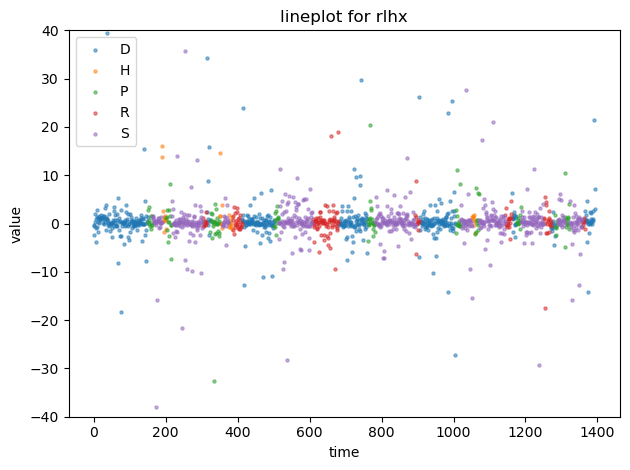

In [65]:
numerical_columns = ['rlhx']
phase_data = {}
phases=rlhx['phase'].unique()

for phase, group in rlhx.groupby('phase'):
    phase_data[phase] = group[numerical_columns]
for i,col in enumerate(numerical_columns):
    for (phase, values) in (phase_data.items()):
        plt.scatter(values.index,values[col], alpha=0.5,s=5, label=phase) 
        
    plt.xlabel('time')
    plt.ylabel('value')
    plt.title(f'lineplot for {col}')
    plt.legend()
plt.ylim(-40,40)
plt.tight_layout()
plt.show()

- jumps in between may indicate change in motion/jerks

In [66]:
def add_r(X):
    X_train=X.copy()
    X_train['rlhx']=X_train['vlhx']/X_train['alhx']
    return X_train

In [67]:
X_train=add_r(X_train)

In [68]:
rnd_clf = RandomForestClassifier(n_estimators=500,n_jobs=-1)
rnd_clf.fit(X_train, y_train)
X_test=add_r(X_test)
cm=confusion_matrix(y_test,rnd_clf.predict(X_test))
cm

C:\Users\sarit\AppData\Local\Temp\ipykernel_31544\1198450240.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rnd_clf.fit(X_train, y_train)


array([[125,   0,   0,   4,  10],
       [  3,   0,   0,   0,   5],
       [  9,   0,   2,   1,  21],
       [  8,   0,   0,  14,  16],
       [  5,   0,   0,   1, 125]], dtype=int64)

it is a little better at predicting preparation phase(marked by velocity change)

In [69]:
f1_score(cm)

(0.4547569099555736,
 0.6308414213718884,
 array([0.8650519 , 0.        , 0.11428571, 0.48275862, 0.81168831]),
 array([0.89928058, 0.        , 0.06060606, 0.36842105, 0.95419847]),
 array([0.83333333, 0.        , 1.        , 0.7       , 0.70621469]))

### final training

In [72]:
def read_csv_files_with_va(folder_path):
    csv_files = {}
    
    # List all files in the folder
    files = os.listdir(folder_path)
    
    # Filter files that start with the specified prefix and end with '.csv'
    csv_files_list = [file for file in files if 'va' in file and file.endswith('.csv')]
    
    # Read CSV files using pandas and store in the dictionary
    for csv_file in csv_files_list:
        file_path = os.path.join(folder_path, csv_file)
        data = pd.read_csv(file_path)
        csv_files[csv_file.replace(".csv","")] = data
    
    return csv_files
data_f=read_csv_files_with_va('dataset')
data_f=pd.concat(data_f)

In [73]:
data_f

1         2         3         4         5         6  \
a1_va3 0    -0.005009 -0.000964  0.000573  0.008623  0.005667  0.001302   
       1     0.004905  0.001209 -0.000649  0.004737  0.003166  0.000819   
       2    -0.002393 -0.000216  0.000136  0.003028  0.001212  0.000336   
       3    -0.001394 -0.000242  0.000056  0.001182  0.000575  0.000225   
       4    -0.000156 -0.000004  0.000023  0.001585  0.000630  0.000094   
...               ...       ...       ...       ...       ...       ...   
c3_va3 1439 -0.003709 -0.006168  0.000786 -0.000155  0.001088 -0.000144   
       1440 -0.000727  0.001536 -0.000211  0.000700 -0.000975  0.000067   
       1441  0.003074  0.007870 -0.000962  0.000526 -0.000779  0.000090   
       1442  0.003297  0.008467 -0.001035  0.000578 -0.000740  0.000101   
       1443  0.000204 -0.000040  0.000058  0.000586 -0.000619  0.000087   

                    7         8         9        10  ...            24  \
a1_va3 0    -0.000631  0.000130 -0.000048  0.007762  ...  1.880800e-04   
       1    -0.000572 -0.000015  0.000023  0.002706  ... -7.500000e-07   
       2    -0.000449  0.000017  0.000047  0.002868  ... -3.920000e-05   
       3    -0.000479 -0.000050  0.000104  0.001171  ... -3.184000e-05   
       4    -0.000303  0.000097  0.000065  0.001579  ... -2.015000e-05   
...               ...       ...       ...       ...  ...           ...   
c3_va3 1439 -0.003815 -0.004658  0.000656  0.000060  ... -9.400000e-07   
       1440 -0.001147  0.000177  0.000008  0.000423  ...  1.234000e-05   
       1441  0.002786  0.005035 -0.000606  0.000413  ...  2.327000e-05   
       1442  0.002947  0.005385 -0.000652  0.000580  ...  1.541000e-05   
       1443  0.000229  0.000003  0.000061  0.000644  ...  3.200000e-07   

                   25        26        27        28        29        30  \
a1_va3 0     0.005133  0.010400  0.000646  0.007871  0.004631  0.000963   
       1     0.005093  0.005756  0.000573  0.003459  0.000730  0.000332   
       2     0.002406  0.003279  0.000452  0.003261  0.002412  0.000852   
       3     0.001416  0.001334  0.000493  0.001358  0.000313  0.000611   
       4     0.000158  0.001709  0.000325  0.001713  0.000203  0.000069   
...               ...       ...       ...       ...       ...       ...   
c3_va3 1439  0.007240  0.001109  0.006056  0.000173  0.001976  0.000137   
       1440  0.001712  0.001202  0.001160  0.000515  0.002600  0.000701   
       1441  0.008504  0.000944  0.005786  0.000431  0.002007  0.000071   
       1442  0.009145  0.000944  0.006173  0.000699  0.000229  0.000023   
       1443  0.000216  0.000857  0.000237  0.000808  0.002763  0.000037   

                   31        32  Phase  
a1_va3 0     0.000092  0.000438      D  
       1     0.000012  0.000433      D  
       2     0.000042  0.000202      D  
       3     0.000029  0.000596      D  
       4     0.000038  0.000069      D  
...               ...       ...    ...  
c3_va3 1439  0.001575  0.000051      D  
       1440  0.001738  0.000124      D  
       1441  0.001697  0.000112      D  
       1442  0.000139  0.000113      D  
       1443  0.001840  0.000036      D  

[8613 rows x 33 columns]

In [74]:
train_set, test_set = train_test_split(data_f, test_size=0.05,stratify=data_f['Phase'], random_state=42)

In [75]:
oe=OrdinalEncoder()
train_set_f=train_set.copy()
train_set_f['Phase']=oe.fit_transform(np.array(train_set['Phase']).reshape(-1,1))
X_train =train_set_f[train_set.columns[:-1]]
y_train=train_set_f[train_set.columns[-1:]]

In [76]:
scaler=StandardScaler()
X_train=pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns)

In [77]:
test_set['Phase']=oe.transform(np.array(test_set['Phase']).reshape(-1,1))
X_test_f =test_set[test_set.columns[:-1]]
y_test_f=test_set[test_set.columns[-1:]]
X_test_f=pd.DataFrame(scaler.transform(X_test_f),columns=X_test_f.columns)

In [78]:
rnd_clf=RandomForestClassifier(n_estimators=500,n_jobs=-1)
rnd_clf.fit(X_train,y_train)

C:\Users\sarit\AppData\Local\Temp\ipykernel_31544\375222370.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rnd_clf.fit(X_train,y_train)


RandomForestClassifier(n_estimators=500, n_jobs=-1)

In [79]:
cm=confusion_matrix(y_train,rnd_clf.predict(X_train))
cm

array([[2139,    0,    0,    0,    0],
       [   0,  897,    0,    0,    0],
       [   0,    0, 1802,    0,    0],
       [   0,    0,    0,  951,    0],
       [   0,    0,    0,    0, 2393]], dtype=int64)

In [80]:
cm=confusion_matrix(y_test_f,rnd_clf.predict(X_test_f))
cm

array([[ 96,   1,   3,   4,   9],
       [ 14,  20,   3,   2,   8],
       [ 13,   3,  54,   0,  25],
       [ 10,   0,   2,  18,  20],
       [ 10,   1,  13,   1, 101]], dtype=int64)

In [81]:
f1_score(cm)

(0.6239623221837756,
 0.6352177293376635,
 array([0.75      , 0.55555556, 0.63529412, 0.48      , 0.69896194]),
 array([0.84955752, 0.42553191, 0.56842105, 0.36      , 0.8015873 ]),
 array([0.67132867, 0.8       , 0.72      , 0.72      , 0.6196319 ]))

In [82]:
np.fill_diagonal(cm,0)

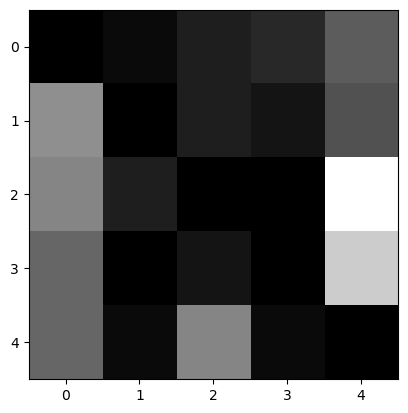

In [83]:
plt.imshow(cm,cmap='gray')

- the classifier is higly confused in assigning hold,preparation,reaction and assigns them to either stroke or rest

In [84]:
oe.categories_

[array(['D', 'H', 'P', 'R', 'S'], dtype=object)]

- the classfier confuses between 'P' AND 'S' or preparation and stroke (understandable-preprartion leads to stroke so they will be close)
- same is for 'R'

In [85]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
rnd_clf4=RandomForestClassifier(n_estimators=500,n_jobs=-1)
param_grid = {
  'max_depth': [10,20,30],
    'n_estimators':[100,200,300]
}
c_v =StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=rnd_clf4, param_grid=param_grid,cv=c_v, n_jobs=-1,return_train_score=True, verbose=4)
grid_search.fit(X_train,y_train)
print('Best hyperparameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


C:\Users\sarit\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Best hyperparameters: {'max_depth': 20, 'n_estimators': 300}
Best score: 0.6715957886111191


In [86]:
test=pd.read_csv('dataset//test.csv')
test_f=scaler.transform(test)

In [87]:
sub=pd.DataFrame()
sub['ID']=list(range(1,1261,1))
sub['Phase']=pd.DataFrame(oe.inverse_transform(grid_search.predict(test_f).reshape(-1,1)),columns=['Phase'])

C:\Users\sarit\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [88]:
sub.to_csv('sub1.csv',index=False)

In [89]:
test=pd.read_csv('dataset//test//a2_va3.csv')

In [90]:
test['Phase']=oe.transform(np.array(test['Phase']).reshape(-1,1))
X_test =test[test.columns[:-1]]
y_test_f1=test[test.columns[-1:]]
X_test_f1=pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)

In [91]:
np.mean(grid_search.predict(X_test_f)==np.array(y_test_f['Phase']))

0.6635730858468677

In [92]:
oe.inverse_transform(grid_search.predict(X_test_f1).reshape(-1,1))

array([['D'],
       ['D'],
       ['D'],
       ...,
       ['D'],
       ['R'],
       ['R']], dtype=object)